# BDD

Using pyeda to create Binary Decision Diagrams of Exact and Approximated Adders. With the BDDs the max error and the number of errors are calculated.

https://pyeda.readthedocs.io/en/latest/index.html

TODO: 
* reorder input to shorten BDD
* Improve function "substract_abs", which is used for the abs error, should not take so long. (I think)
* Maybe max_error can be made faster.

Timing on my (Martin) PC:
 
|          |  8 Bit           | 10 Bit         | 11 Bit           | 12 Bit         |
|----------|----------------- |----------------|------------------|----------------|
| exact    | 0:00:00.201877  | 0:00:01.630912  | 0:00:04.763647   | 0:00:13.682405 |
| inxa1    | 0:00:00.461063  | 0:00:07.504904  | 0:00:30.332356   | 0:02:01.310607 | 
| abs error | 0:00:13.609947 | 0:03:28.898941  | 0:14:05.812849   | stopped after 30 minutes|
| get highest| 0:00:00.311432 | 0:00:23.046027 | 0:18:57.557590 | - |

compared to Peters Method: 
* 0:00:05.505999 for 8 Bits
* 0:17:54.364350 for 10 Bits

Note:
 error without abs takes 0:01:40.345370 for 10 bit

The BDD after the abs_error could be saved for all further analyzes.
    

## VHDL from Kagan

-- Full adder (exact)

S <= A XOR B XOR Cin ;

Cout <= (A AND B) OR (Cin AND A) OR (Cin AND B) ;

-- Full adder INXA1 (Approx.)

s_inv_1 <= A XOR B XOR Cin ; -- Signal for binding S_a and Cout_a

S_a <= s_inv_1;

Cout_a <= NOT(s_inv_1) ;


In [1]:
# Additional Package for better documentation
from typing import List, Dict

# meassure time
from datetime import datetime

#Import necessary libraries
from pyeda.inter import * # <--this is from the official wiki, don't judge

#GVmagic is a package to use the external GraphViz library inside python
%load_ext gvmagic

#to easily get some multidimensional arrays
import numpy

#from print import pprint

#Libraries needed for the image creation
import pydot
from PIL import Image
from numpy import *

In [2]:
# Define Parameters
INPUT_WIDTH = 10

# Define Global Variables
a = bddvars('A', INPUT_WIDTH)
b = bddvars('B', INPUT_WIDTH)

In [3]:
def get_exact_adder() -> (List[BDDVariable], List[BDDVariable]):
    """
    Returns the BDD's for the Sum and the Carry of an exact adder
    """
    co = bddvars(('exact', 'CO'), INPUT_WIDTH)
    s = bddvars(('exact', 'S'), INPUT_WIDTH+1)

    s[0] = a[0] ^ b[0]
    co[0] = a[0] & b[0]

    for i in range(1, INPUT_WIDTH, 1):    
        s[i] = a[i] ^ b[i] ^ co[i-1]
        co[i] = (a[i] & b[i]) | (co[i-1] & a[i]) | (co[i-1] & b[i])
        
    s[INPUT_WIDTH] = co[INPUT_WIDTH-1]
        
    return s, co

In [4]:
def get_exact_adder_v2() -> (List[BDDVariable], List[BDDVariable]):
    """
    Returns the BDD's for the Sum and the Carry of an exact adder
    """
    co = bddvars(('exact2', 'CO'), INPUT_WIDTH)
    s = bddvars(('exact2', 'S'), INPUT_WIDTH)
    
    #xor is slow
    s[0] = (a[0] & ~b[0]) | (~a[0] & b[0])
    #s[0] = a[0] ^ b[0]
    co[0] = a[0] & b[0]

    for i in range(1, INPUT_WIDTH, 1):    
        s[i] =  (a[i] & ~b[i] & ~co[i-1]) | \
                (~a[i] & b[i] & ~co[i-1]) | \
                (~a[i] & ~b[i] & co[i-1]) | \
                (a[i] & b[i] & co[i-1])
        
        co[i] = (a[i] & b[i]) | (co[i-1] & a[i]) | (co[i-1] & b[i])
        
    return s, co

In [5]:
def get_INXA1_adder() -> (List[BDDVariable], List[BDDVariable]): 
    """
    Returns the BDD's for the Sum and the Carry of the approximation
    """
    co = bddvars(('INXA1', 'CO'), INPUT_WIDTH)
    s = bddvars(('INXA1', 'S'), INPUT_WIDTH+1)

    s[0] = a[0] ^ b[0]
    co[0] = ~s[0]

    for i in range(1, INPUT_WIDTH, 1):    
        s[i] = a[i] ^ b[i] ^ co[i-1]
        co[i] = ~s[i] 

    s[INPUT_WIDTH] = co[INPUT_WIDTH-1]
        
    return s, co

In [6]:
def get_INXA1_adder_v2() -> (List[BDDVariable], List[BDDVariable]): 
    """
    Returns the BDD's for the Sum and the Carry of the approximation
    """
    co = bddvars(('INXA1', 'CO'), INPUT_WIDTH)
    s = bddvars(('INXA1', 'S'), INPUT_WIDTH)

    s[0] = a[0] ^ b[0]
    co[0] = ~s[0]

    for i in range(1, INPUT_WIDTH, 1):    
        s[i] = a[i] ^ b[i] ^ co[i-1]
        co[i] = (a[i] & b[i] & ~co[i-1]) | \
                (a[i] & ~b[i] & co[i-1]) | \
                (~a[i] & b[i] & co[i-1]) | \
                (~a[i] & ~b[i] & ~co[i-1])
    
    return s, co

In [7]:
def get_INXA1_adder_v3() -> (List[BDDVariable], List[BDDVariable]): 
    """
    Returns the BDD's for the Sum and the Carry of the approximation
    """
    co = bddvars(('INXA1', 'CO'), INPUT_WIDTH)
    s = bddvars(('INXA1', 'S'), INPUT_WIDTH)

    s[0] = a[0] ^ b[0]
    co[0] = ~(a[0] ^ b[0])

    for i in range(1, INPUT_WIDTH, 1):    
        s[i] = a[i] ^ b[i] ^ co[i-1]
        co[i] = ~(a[i] ^ b[i] ^ co[i-1])

        
        
    return s, co

In [8]:
def substract_abs(add_a, add_b):
    
    a = bddvars(('SUB_ABS', 'a'), INPUT_WIDTH+2)
    b = bddvars(('SUB_ABS', 'b'), INPUT_WIDTH+2)
    co = bddvars(('SUB_ABS', 'CO'), INPUT_WIDTH+2)    
    h = bddvars(('SUB_ABS', 'h'), INPUT_WIDTH+2)
    
    #build 2-complement of b: invert b and set carry_in[0] to 1
    for i in range(0, INPUT_WIDTH+1, 1):
        a[i] = add_a[i]
        b[i] = ~add_b[i]
    
    a[INPUT_WIDTH+1] = expr2bdd(expr(0))
    b[INPUT_WIDTH+1] = expr2bdd(expr(1))
    
    h[0] = ~(a[0] ^ b[0])  # = a^b^1
    co[0] = a[0] | b[0]   # = a & b | a & 1 | b & 1

    for i in range(1, INPUT_WIDTH+2, 1):  # plus 1 because sum is longer then original input
        h[i] = a[i] ^ b[i] ^ co[i-1]
        co[i] = (a[i] & b[i]) | (co[i-1] & a[i]) | (co[i-1] & b[i])
    
    
    
    # h[INPUT_WIDTH+2] = co[INPUT_WIDTH+1] useless line -> never overlow when substracting 2 positiv numbers
    
    # h is now add_a - add_b
    
    ## Invert h if negativ:
    mask = h[INPUT_WIDTH+1]  # msb = negative number
    co2 = bddvars(('SUB_ABS', 'CO2'), INPUT_WIDTH+2)    
    h2 = bddvars(('SUB_ABS', 'CO2'), INPUT_WIDTH+2)
    s = bddvars(('SUB_ABS', 'S'), INPUT_WIDTH+3)
    
    for i in range(0, INPUT_WIDTH+2, 1):
        h2[i] = h[i] ^ mask
    
    s[0] = h2[0] ^ mask
    co2[0] = h2[0] & mask

    for i in range(1, INPUT_WIDTH+2, 1):    
        s[i] = h2[i] ^ co2[i-1]
        co2[i] = h2[i] & co2[i-1]
        
    s[INPUT_WIDTH+2] = co2[INPUT_WIDTH+1] # should always be 0 but good sanity check
        
    return s

### Run the following Cells only once

generating BDD's is a heavy load for Processor
but this only needs to be done once

In [9]:
t = datetime.now()
s_exact, co_exact = get_exact_adder()
print("exact:   \t", datetime.now() - t)
print("number of bits:", INPUT_WIDTH)

exact:   	 0:00:01.677865
number of bits: 10


In [10]:
t = datetime.now()
s_inxa1, co_inxa1 = get_INXA1_adder()
print("inxa1:   \t", datetime.now() - t)
print("number of bits:", INPUT_WIDTH)

inxa1:   	 0:00:08.196673
number of bits: 10


In [11]:

t = datetime.now()
abs_error = substract_abs(s_exact, s_inxa1)
print("abs error:   \t", datetime.now() - t)
print("number of bits:", INPUT_WIDTH)



abs error:   	 0:03:48.107756
number of bits: 10


### End heavy load

#### Speed Test:

In [12]:
if False:
    old_INPUT_WIDTH = INPUT_WIDTH
    INPUT_WIDTH = 10# set it so the check can be made in reasonable time
    
    print("TimeTest:\n")
    
    t = datetime.now()
    exact_sum_v0, exact_carry_v0 = get_exact_adder()
    print("exact:   \t", datetime.now() - t)
    
    t = datetime.now()
    exact_sum_v2, exact_carry_v2 = get_exact_adder_v2()
    print("exact_v2:\t", datetime.now() - t)
    
    equal = True
    for i in range(INPUT_WIDTH):
        if not(exact_sum_v0[i].equivalent(exact_sum_v2[i])):
            equal = False
    print("Adders are equal: \t", equal)
    
    print("\n")
    ##### INXA1 #################################################
    t = datetime.now()
    inxa1_sum_v0, inxa1_carry_v0 = get_INXA1_adder()
    print("inxa1:   \t", datetime.now() - t)
    
    t = datetime.now()
    inxa1_sum_v2, inxa1_carry_v2 = get_INXA1_adder_v2()
    print("inxa1_v2:\t", datetime.now() - t)
    
    t = datetime.now()
    inxa1_sum_v3, inxa1_carry_v3 = get_INXA1_adder_v3()
    print("inxa1_v3:\t", datetime.now() - t)
    
    equal = True
    for i in range(INPUT_WIDTH):
        if not(inxa1_sum_v0[i].equivalent(inxa1_sum_v2[i])):
            equal = False
        if not(inxa1_sum_v0[i].equivalent(inxa1_sum_v3[i])):
            equal = False
    print("INXA1 are equal: \t", equal)
    
    
    INPUT_WIDTH = old_INPUT_WIDTH  # use old value afterwards

In [13]:
def max_error(appr_not_eq_exact):
    
    # search for highest bit which can be false
    for bit in range(INPUT_WIDTH, -1, -1):
        error_ = appr_not_eq_exact[bit]
        restrictions = list(error_.satisfy_all())
        if len(restrictions) > 0:
            new_bit = bit
            break

    res_new = restrictions    

    bit = new_bit -1
    while(bit > -1):
            
        if len(res_new) > 0:
            # if prev bit was satisfied use new set of restrictions
            restrictions = res_new.copy()
            
            for r in restrictions:
                # check if restriction setisfies bit, if not remove it
                if not(appr_not_eq_exact[bit].restrict(r)):
                    res_new.remove(r)

            bit = bit -1
        else:
            res_new = restrictions
            # no restriction found which satisfies bit -> revert
            continue
            
    return restrictions
        

In [14]:


t = datetime.now()
restrictions = max_error(abs_error)
print("calculate restrictions/get highest error:   \t", datetime.now() - t)
print("number of bits:", INPUT_WIDTH)


print("\nNumber of restrictions", len(restrictions))

for r in restrictions:
    print(r)


print("\nDifferences (should always be the same):")
for r in restrictions:
    for i in range(INPUT_WIDTH, -1, -1):
        x = abs_error[i].restrict(r)
        print(x, end = " ")
    print()
    
print("\nExact:")
for r in restrictions:
    for i in range(INPUT_WIDTH, -1, -1):
        x = s_exact[i].restrict(r)
        print(x, end = " ")
    print()
    
print("\nINXA1:")
for r in restrictions:
    for i in range(INPUT_WIDTH, -1, -1):
        x = s_inxa1[i].restrict(r)
        print(x, end = " ")
    print()

calculate restrictions/get highest error:   	 0:00:24.244176
number of bits: 10

Number of restrictions 3
{A[0]: 0, A[1]: 0, A[2]: 0, A[3]: 0, A[4]: 0, A[5]: 0, A[6]: 0, A[7]: 0, A[8]: 0, A[9]: 0, B[0]: 1, B[1]: 0, B[2]: 0, B[3]: 0, B[4]: 0, B[5]: 0, B[6]: 0, B[7]: 0, B[8]: 0, B[9]: 0}
{A[0]: 1, A[1]: 0, A[2]: 0, A[3]: 0, A[4]: 0, A[5]: 0, A[6]: 0, A[7]: 0, A[8]: 0, A[9]: 0, B[0]: 0, B[1]: 0, B[2]: 0, B[3]: 0, B[4]: 0, B[5]: 0, B[6]: 0, B[7]: 0, B[8]: 0, B[9]: 0}
{A[0]: 1, A[1]: 1, A[2]: 1, A[3]: 1, A[4]: 1, A[5]: 1, A[6]: 1, A[7]: 1, A[8]: 1, A[9]: 1, B[0]: 1, B[1]: 1, B[2]: 1, B[3]: 1, B[4]: 1, B[5]: 1, B[6]: 1, B[7]: 1, B[8]: 1, B[9]: 1}

Differences (should always be the same):
1 0 1 0 1 0 1 0 1 0 0 
1 0 1 0 1 0 1 0 1 0 0 
1 0 1 0 1 0 1 0 1 0 0 

Exact:
0 0 0 0 0 0 0 0 0 0 1 
0 0 0 0 0 0 0 0 0 0 1 
1 1 1 1 1 1 1 1 1 1 0 

INXA1:
1 0 1 0 1 0 1 0 1 0 1 
1 0 1 0 1 0 1 0 1 0 1 
0 1 0 1 0 1 0 1 0 1 0 


# END

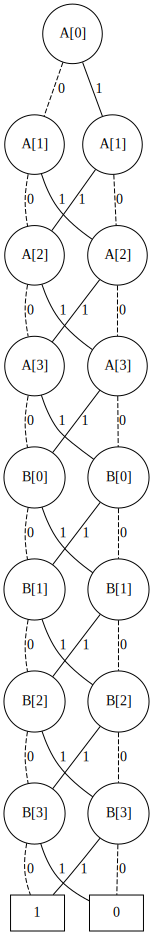

In [15]:
%dotobj s_inxa1[3]

In [16]:
expr2truthtable(s_inxa1[3])

B[3] B[2] B[1] B[0] A[3] A[2] A[1] A[0]
   0    0    0    0    0    0    0    0 : 1
   0    0    0    0    0    0    0    1 : 0
   0    0    0    0    0    0    1    0 : 0
   0    0    0    0    0    0    1    1 : 1
   0    0    0    0    0    1    0    0 : 0
   0    0    0    0    0    1    0    1 : 1
   0    0    0    0    0    1    1    0 : 1
   0    0    0    0    0    1    1    1 : 0
   0    0    0    0    1    0    0    0 : 0
   0    0    0    0    1    0    0    1 : 1
   0    0    0    0    1    0    1    0 : 1
   0    0    0    0    1    0    1    1 : 0
   0    0    0    0    1    1    0    0 : 1
   0    0    0    0    1    1    0    1 : 0
   0    0    0    0    1    1    1    0 : 0
   0    0    0    0    1    1    1    1 : 1
   0    0    0    1    0    0    0    0 : 0
   0    0    0    1    0    0    0    1 : 1
   0    0    0    1    0    0    1    0 : 1
   0    0    0    1    0    0    1    1 : 0
   0    0    0    1    0    1    0    0 : 1
   0    0    0    1    0    1    0  